# Simulate a System with Noise
## With feedback control

In [12]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists): 
    !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

from numpy import eye, array, asarray, exp

from sympy import Matrix, init_printing
init_printing()

from scipy.linalg import expm, solve_continuous_lyapunov, sqrtm
from math import *

np.random.seed(100)

Running Python: 3.8.16


In [13]:
#linearized dynamics of the system
A = np.array([[0, 1, 0, 0], [0, -0.415, -0.011, 0], [9.8, -1.43, -0.0198, 0], [0, 0, 1, 0]])
na,_ = A.shape
Bw = np.array([0, -0.011, -0.0198, 0]).reshape(na,1)
Bu = np.array([0, 6.27, 9.8, 0]).reshape(na,1)
Cz = np.array([0, 0, 0, 1]).reshape(1,na)

In [14]:
# solve cts steady state LQR problem
K,_ = lqr(A,Bu,Cz.T@Cz,5.0)

In [15]:
# cts process noise intensity
Wc = np.array([4.75])

# initial response with given x0
x0 = np.array([0, 0, 0, .25]).reshape(na,1)
x0a = np.array([0, 0, 0, .25, 0]).reshape(na+1,1)

dt = np.sqrt(np.array(2.0))/100; # small discrete step to simulate the cts dynamics
tf = 180
t = np.arange(0,tf+dt,dt)

In [16]:
# add shaping filter for the process noise
Ah = np.array([-0.2])
Bh = np.array([6])
Ch = np.array([1])

#augment the filter dyanmics to the system
Aa = np.vstack((np.hstack((A,Bw*Ch)),np.hstack((np.zeros((1,na))[0,:], Ah))))
Bua = np.vstack((Bu,0))
Bwa = np.vstack((np.zeros((na,1)), Bh))
Cza = np.hstack((Cz[0,:],np.array([0])))

In [17]:
# now augment the LQR gain in the case that it does not use the state of
# the shaping filter
Ka = np.hstack((K[0,:],np.array([0]))) # i.e. no dist FF

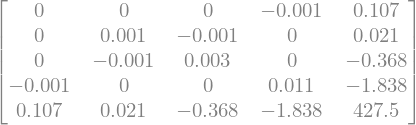

In [18]:
# find the closed loop system dynamics
Acla = Aa-Bua@Ka.reshape(1,na+1) # close the loop 
F = (Acla,Bwa,Cza,0) # closed loop from proce noise in to performance out

Qass = la.solve_continuous_lyapunov(Acla, -Bwa@np.atleast_2d(Wc)@Bwa.T)
display(Matrix(np.round(Qass,3)))
vx = np.sqrt(Cza@Qass@Cza.T) # state resp

In [19]:
def DiscretizeW(A,Bw,Wc,Bu,dt = 1):
    Nx = A.shape[0]
    # find Ad and Wd
    S = np.zeros([2*Nx,2*Nx])
    S[0:Nx,0:Nx] = -A
    S[0:Nx,Nx:2*Nx] = Bw@np.atleast_2d(Wc)@Bw.T
    S[Nx:2*Nx,Nx:2*Nx] = A.T
    CC = expm(S*dt)
    Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
    Wd = Ad@CC[0:Nx,Nx:2*Nx]

    # now find Bd
    Nu = Bu.shape[1]
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu
    CC = expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]
    return Wd, Ad, Bd 

In [20]:
def lsim(F,w,t,x0,useB = False):
    Npts = len(t)
    Ac,Bw,Cz,_ = F
    _,Ad,Bd = DiscretizeW(Ac,Bw,Wc,Bw,t[1] - t[0])
    nd,_ = Ad.shape

    X = np.zeros((nd,1,Npts+1))
    X[:,0,0] = x0[:,0]
    for k in enumerate(t):
        if useB:
            X[:,0,k[0]+1] = Ad@X[:,0,k[0]] + (Bd*w[0,k[0]]).reshape(1,na+1)
        else:
            X[:,0,k[0]+1] = Ad@X[:,0,k[0]] + w[:,k[0]]
    return X
    
# To do the sim right the Wc of the process noise must be divided by Ts
Randstore = randn(1,len(t))
w_meth1 = sqrt(Wc/dt)*Randstore # discrete equivalent noise for "cts" sim
w_wrong = sqrt(Wc*dt)*Randstore # wrong way of scaling noise
X_cts = lsim(F,w_meth1,t,x0a,useB=True); # cts closed-loop sim
X_wrong = lsim(F,w_wrong,t,x0a,useB=True); # cts closed-loop sim

Randstore2 = np.vstack((randn(na,len(t)),Randstore))
Wd,_,_ = DiscretizeW(Acla,Bwa,Wc,Bwa,dt)
w = sqrtm(Wd)@Randstore2 # discrete equivalent noise for "cts" sim
X_dis1 = lsim(F,w,t,x0a,useB=False); # cts closed-loop sim

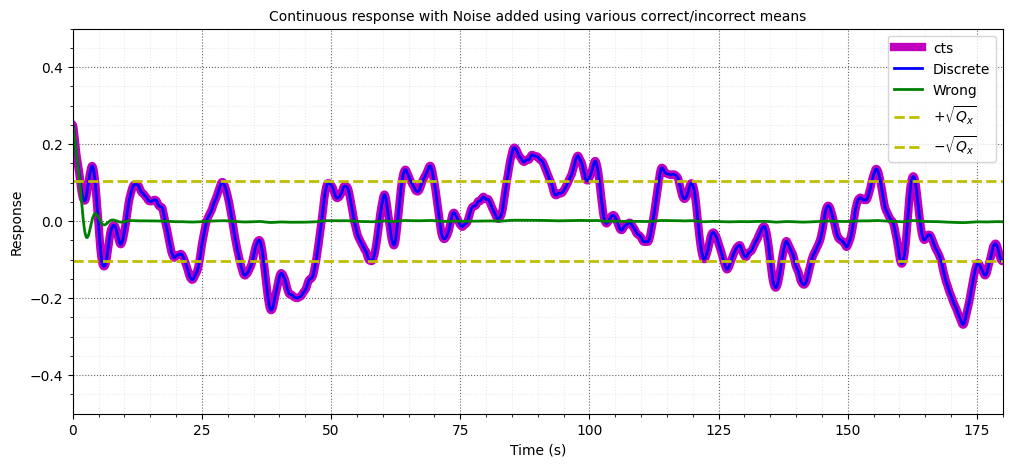

In [21]:
plt.figure(2,figsize=(12,5))
plt.plot(t, X_cts[3,0,:-1], 'm-', lw=6, label=r'cts')
plt.plot(t, X_dis1[3,0,:-1], 'b-', lw=2,label=r'Discrete')
plt.plot(t, X_wrong[3,0,:-1], 'g-', label=r'Wrong')
plt.plot([0, max(t)], [vx, vx], 'y--', label=r'$+\sqrt{Q_x}$')
plt.plot([0, max(t)], [-vx, -vx], 'y--', label=r'$-\sqrt{Q_x}$')
plt.legend()
plt.title('Continuous response with Noise added using various correct/incorrect means')
plt.xlim([0, max(t)])
plt.ylim([-0.5, 0.5])
plt.xlabel(r'Time (s)')
plt.ylabel(r'Response')
nicegrid()
plt.savefig("figs/heli_sim_1.png")
plt.show()

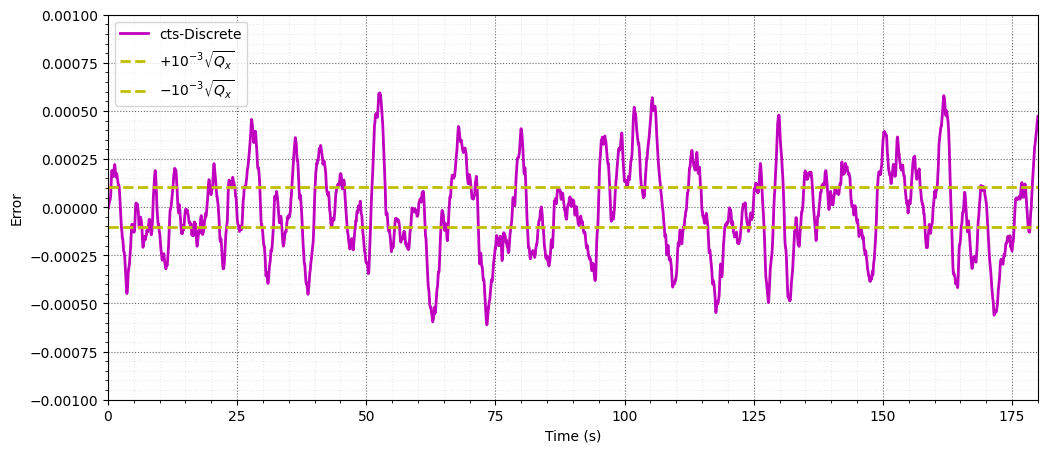

In [22]:
plt.figure(3,figsize=(12,5))
plt.plot(t, X_cts[3,0,:-1]-X_dis1[3,0,:-1], 'm-', lw=2, label=r'cts-Discrete')
plt.plot([0, max(t)], [vx/1000, vx/1000], 'y--', label=r'$+10^{-3}\sqrt{Q_x}$')
plt.plot([0, max(t)], [-vx/1000, -vx/1000], 'y--', label=r'$-10^{-3}\sqrt{Q_x}$')
plt.legend()
#plt.title('Continuous LQR $P$ using $t_f=$'+str(Tf)+'s')
plt.xlim([0, max(t)])
plt.ylim([-1e-3, 1e-3])
plt.xlabel(r'Time (s)')
plt.ylabel(r'Error')
nicegrid()
plt.savefig("figs/heli_sim_2.png")
plt.show()